# Subclass DE isoform hidden by gene

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

10-Nov-20 15:39:52 - 1 of 18 assignments: Astro
10-Nov-20 15:39:53 - 2 of 18 assignments: Endo
10-Nov-20 15:39:53 - 3 of 18 assignments: L2/3 IT
10-Nov-20 15:39:54 - 4 of 18 assignments: L5 IT
10-Nov-20 15:39:55 - 5 of 18 assignments: L5 PT
10-Nov-20 15:39:56 - 6 of 18 assignments: L5/6 NP
10-Nov-20 15:39:57 - 7 of 18 assignments: L6 CT
10-Nov-20 15:39:57 - 8 of 18 assignments: L6 IT
10-Nov-20 15:39:58 - 9 of 18 assignments: L6 IT Car3
10-Nov-20 15:39:59 - 10 of 18 assignments: L6b
10-Nov-20 15:40:00 - 11 of 18 assignments: Lamp5
10-Nov-20 15:40:01 - 12 of 18 assignments: Low Quality
10-Nov-20 15:40:01 - 13 of 18 assignments: Pvalb
10-Nov-20 15:40:02 - 14 of 18 assignments: SMC
10-Nov-20 15:40:02 - 15 of 18 assignments: Sncg
10-Nov-20 15:40:03 - 16 of 18 assignments: Sst
10-Nov-20 15:40:04 - 17 of 18 assignments: VLMC
10-Nov-20 15:40:04 - 18 of 18 assignments: Vip


CPU times: user 7.9 s, sys: 5.92 s, total: 13.8 s
Wall time: 13.8 s


In [7]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

10-Nov-20 15:40:08 - 1 of 18 assignments: Astro
10-Nov-20 15:40:09 - 2 of 18 assignments: Endo
10-Nov-20 15:40:11 - 3 of 18 assignments: L2/3 IT
10-Nov-20 15:40:12 - 4 of 18 assignments: L5 IT
10-Nov-20 15:40:14 - 5 of 18 assignments: L5 PT
10-Nov-20 15:40:17 - 6 of 18 assignments: L5/6 NP
10-Nov-20 15:40:18 - 7 of 18 assignments: L6 CT
10-Nov-20 15:40:20 - 8 of 18 assignments: L6 IT
10-Nov-20 15:40:22 - 9 of 18 assignments: L6 IT Car3
10-Nov-20 15:40:24 - 10 of 18 assignments: L6b
10-Nov-20 15:40:26 - 11 of 18 assignments: Lamp5
10-Nov-20 15:40:27 - 12 of 18 assignments: Low Quality
10-Nov-20 15:40:29 - 13 of 18 assignments: Pvalb
10-Nov-20 15:40:30 - 14 of 18 assignments: SMC
10-Nov-20 15:40:32 - 15 of 18 assignments: Sncg
10-Nov-20 15:40:33 - 16 of 18 assignments: Sst
10-Nov-20 15:40:35 - 17 of 18 assignments: VLMC
10-Nov-20 15:40:36 - 18 of 18 assignments: Vip


CPU times: user 16.7 s, sys: 17 s, total: 33.6 s
Wall time: 33.6 s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [8]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

setdiff = np.setdiff1d(markers_isoform.name.apply(lambda x: "-".join(x.split("-")[0:-1])), markers_gene[relevant_genes].name.apply(lambda x: x.split("_")[0]))

markers_isoform = markers_isoform[markers_isoform.name.apply(lambda x: "-".join(x.split("-")[0:-1])).isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es
1107174,VLMC,Serpinf1-208_ENSMUST00000168902,5.16089e-06,0.00337006,6.2253
1123472,VLMC,Slc29a1-202_ENSMUST00000064889,6.59709e-06,0.0043079,4.63416
114960,Endo,Ltbp4-205_ENSMUST00000121175,1.68956e-06,0.00109822,3.32118
96539,Endo,Vamp3-203_ENSMUST00000155446,8.95888e-07,0.000582327,1.62091
920814,SMC,Tor1aip1-204_ENSMUST00000124212,4.61856e-07,0.000145023,1.56897
307060,L5 PT,St8sia1-201_ENSMUST00000032421,9.45162e-07,0.00890626,1.14601
924155,SMC,Sass6-208_ENSMUST00000198747,9.69165e-08,3.04318e-05,1.09871
288499,L5 PT,Yy1-201_ENSMUST00000021692,3.7623e-07,0.00354521,0.976575
293304,L5 PT,Lnpep-201_ENSMUST00000041047,5.59841e-07,0.00527539,0.664117
173844,L2/3 IT,Srek1-201_ENSMUST00000074616,6.1897e-24,3.86176e-20,0.557173


In [9]:
specific_cluster = "VLMC"
specific_isoform = "Slc29a1-202_ENSMUST00000064889"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [10]:
specific_gene

'Slc29a1'

In [11]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Slc29a1_ENSMUSG00000023942'], dtype=object)

In [12]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [14]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


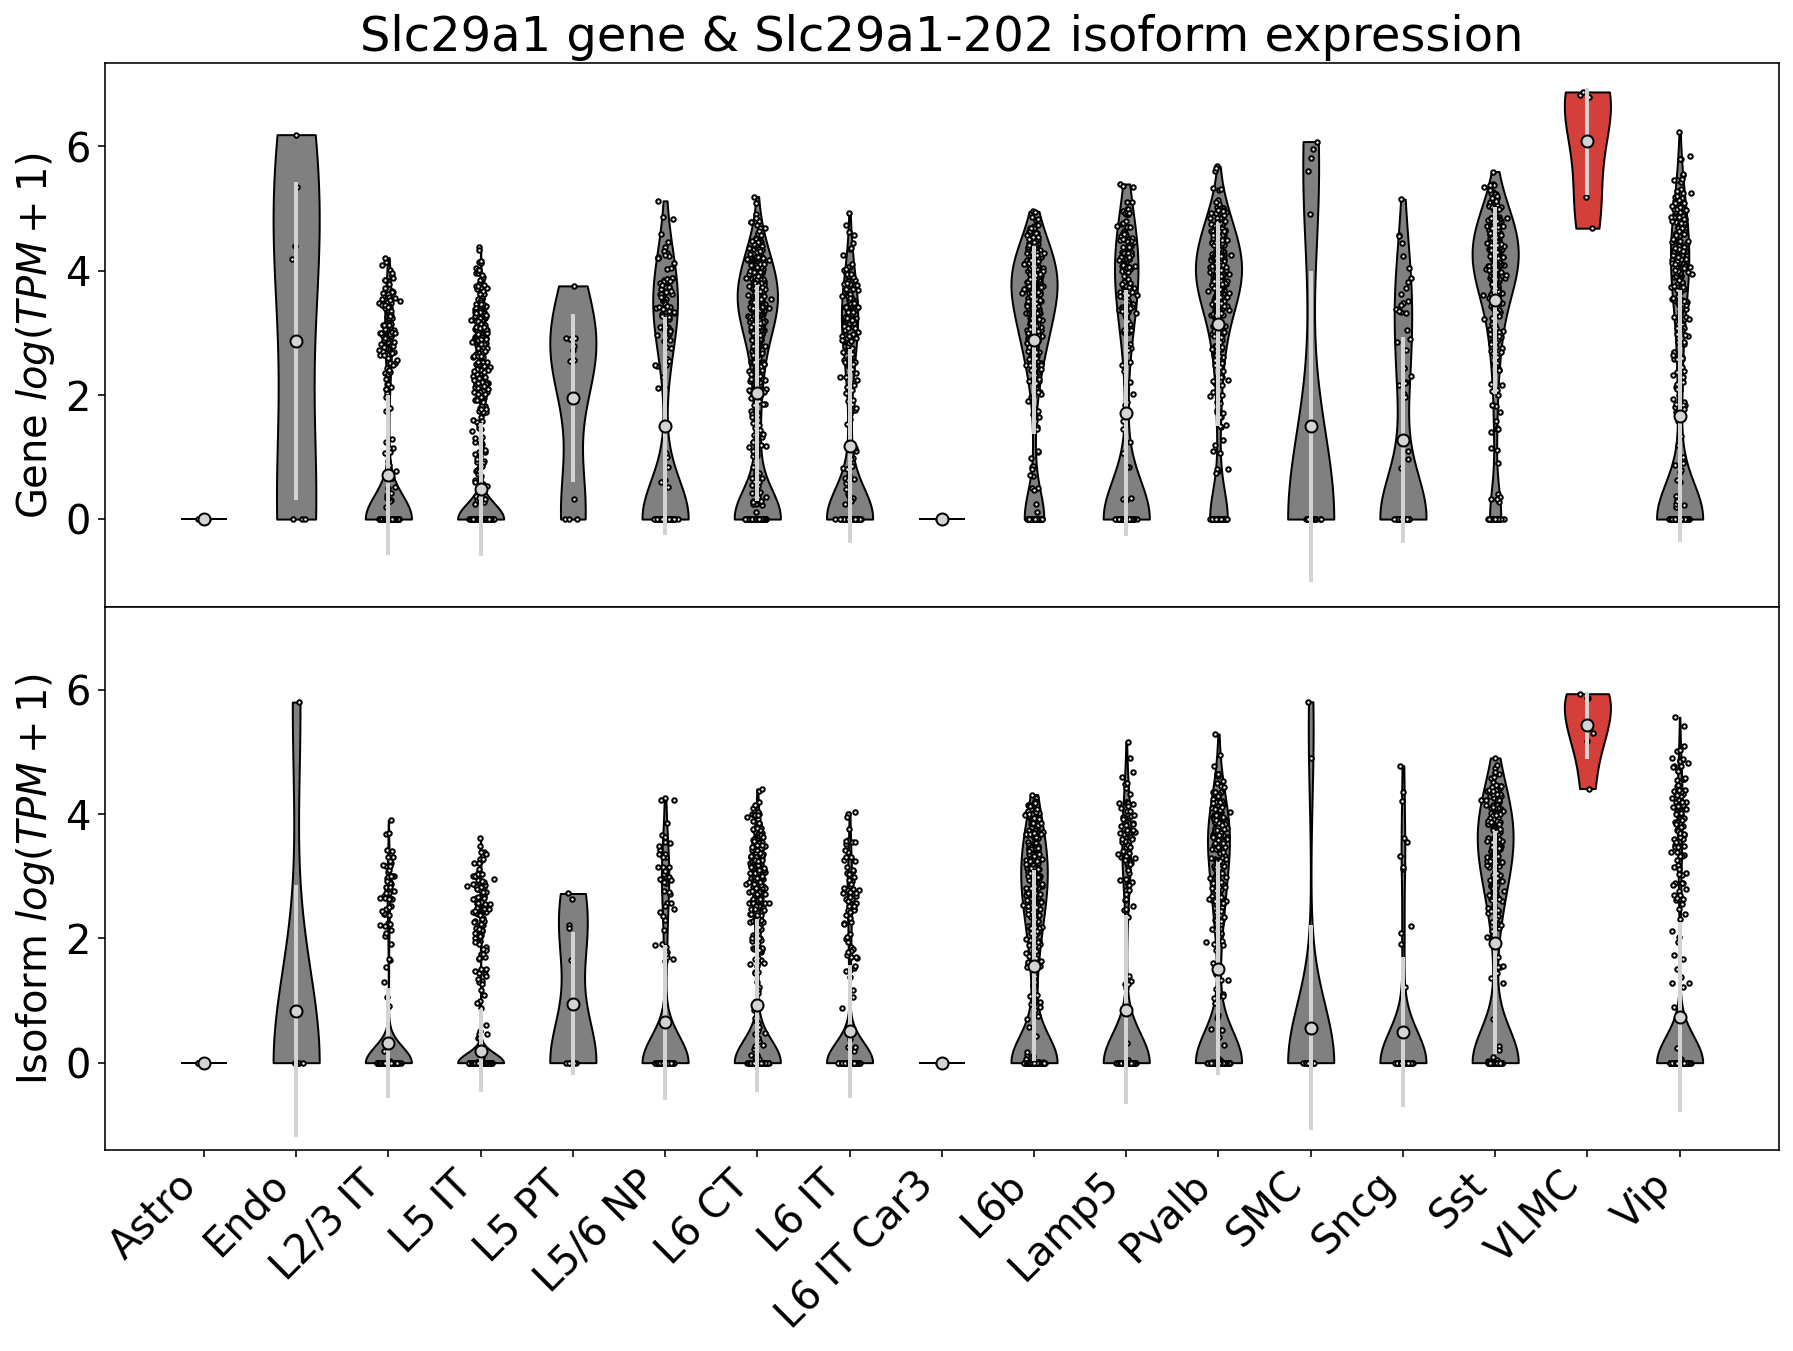

In [17]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)


######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/subclass_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [16]:
markers_gene[markers_gene.name.str.contains("Slc29")]

,index,name,p_raw,p_corr,es
310539,VLMC,Slc29a1_ENSMUSG00000023942,8.4519e-05,0.0649951,4.42327


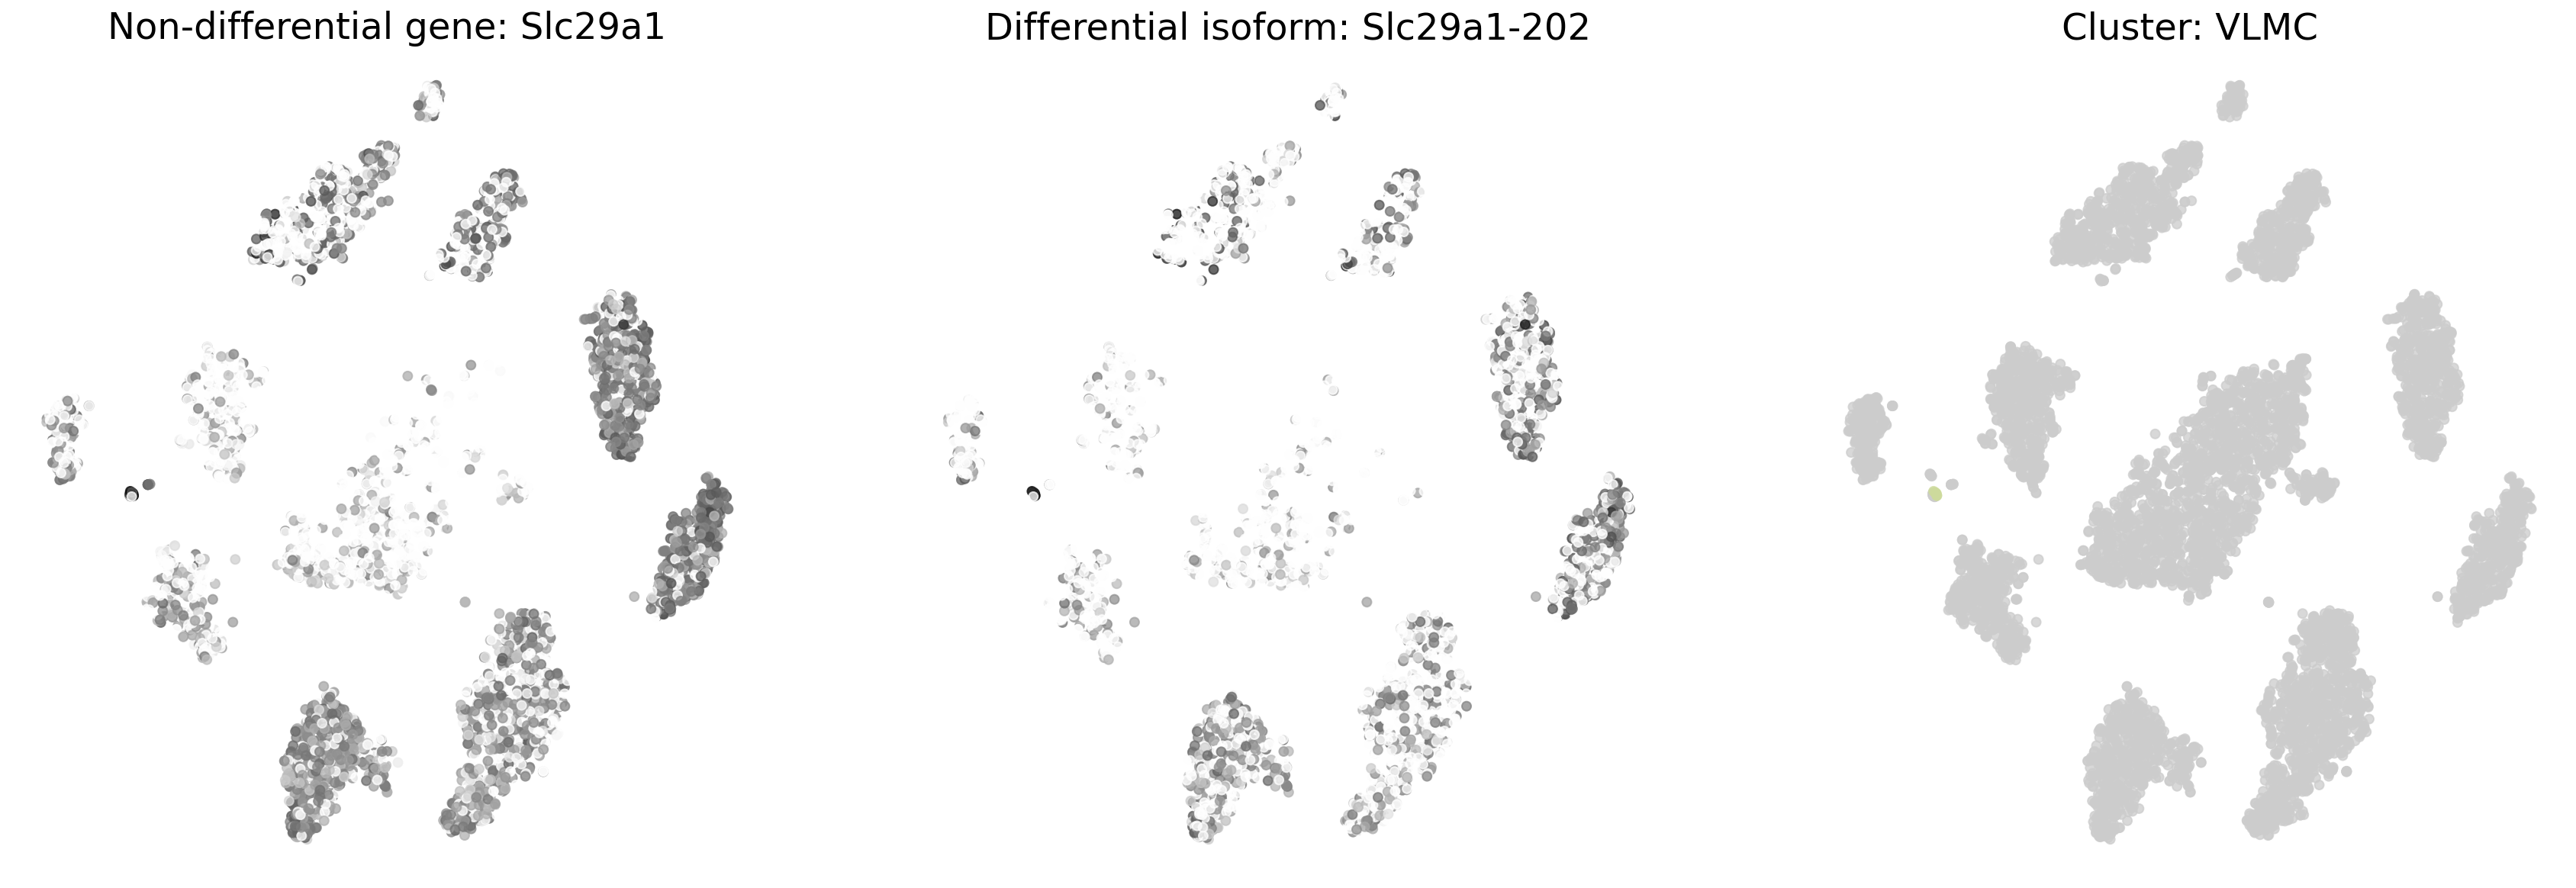

In [18]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
c = np.array(c)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
plt.savefig("../../figures/subclass_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [19]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [20]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [21]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

91 isoforms from 55 genes identified.


In [22]:
markers_isoform.to_csv("../../tables/unordered/subclass_DE.csv")